In [1]:
!pip install tensorflow-gpu==2.0.0-beta1
!pip install tfa-nightly

import tensorflow as tf
import tensorflow_addons as tfa

keras = tf.keras

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
SPLIT_WEIGHTS = (8, 2)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation), metadata = tfds.load('cifar10', split=list(splits), with_info=True, as_supervised=True)
raw_test, metadata = tfds.load('cifar10', split=tfds.Split.TEST, with_info=True, as_supervised=True)

In [0]:
IMG_SIZE = 32

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [7]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            pooling='avg',
                                            weights='imagenet')

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
EMBEDDING_SIZE = 128

model = keras.Sequential([
    base_model,
    keras.layers.Dense(EMBEDDING_SIZE),
    keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))
])

In [0]:
model.compile(optimizer=keras.optimizers.Adagrad(lr=0.05),
              loss=lambda y_true, y_pred: tfa.losses.triplet_semihard_loss(y_true, y_pred, margin=0.2))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
lambda (Lambda)              (None, 128)               0         
Total params: 2,421,952
Trainable params: 2,387,840
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=validation_batches)

Epoch 1/30


W0721 18:46:38.836315 139670730381184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


313/313 [==============================] - 132s 420ms/step - loss: 0.1444 - val_loss: 0.0000e+00
Epoch 2/30
313/313 [==============================] - 77s 246ms/step - loss: 0.1043 - val_loss: 0.1785
Epoch 3/30
313/313 [==============================] - 77s 247ms/step - loss: 0.0863 - val_loss: 0.1599
Epoch 4/30
313/313 [==============================] - 78s 248ms/step - loss: 0.0738 - val_loss: 0.1604
Epoch 5/30
313/313 [==============================] - 77s 247ms/step - loss: 0.0633 - val_loss: 0.1396
Epoch 6/30
313/313 [==============================] - 77s 246ms/step - loss: 0.0554 - val_loss: 0.1328
Epoch 7/30
313/313 [==============================] - 77s 247ms/step - loss: 0.0484 - val_loss: 0.1203
Epoch 8/30
313/313 [==============================] - 77s 247ms/step - loss: 0.0428 - val_loss: 0.1223
Epoch 9/30
313/313 [==============================] - 78s 248ms/step - loss: 0.0371 - val_loss: 0.1199
Epoch 10/30
313/313 [==============================] - 78s 249ms/step - loss: 0

In [0]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

10000/10000 [==============================] - 6s 589us/sample
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.071s...
[t-SNE] Computed neighbors for 10000 samples in 10.394s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.068946
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.225296
[t-SNE] KL dive

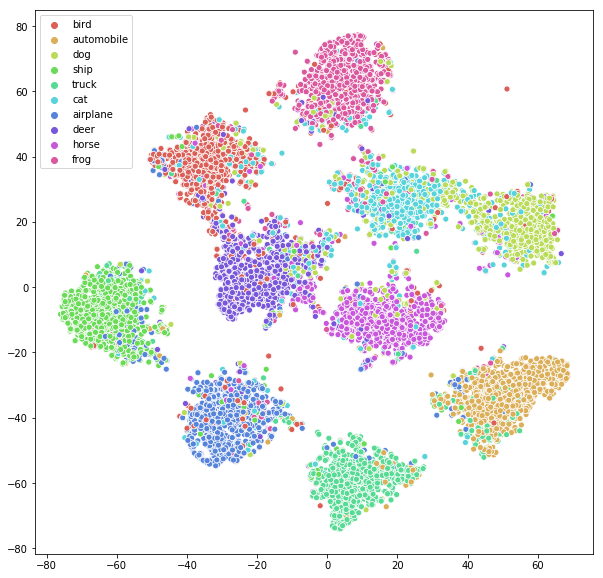

In [13]:
images, labels = [], []
for image_batch, label_batch in test_batches:
    images.append(image_batch)
    labels.append(label_batch)
images, labels = np.concatenate(images), np.concatenate(labels)

embeddings = model.predict(images, verbose=1)
embeddings = TSNE(n_components=2, verbose=1).fit_transform(embeddings)

idx_to_label = {label: metadata.features['label'].names[label] for label in range(metadata.features['label'].num_classes)}
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=[idx_to_label[idx] for idx in labels], palette=sns.color_palette('hls', 10))